In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import newton

In [2]:
# Symbols definition
n = sp.symbols("N") #Number of junctions
k = sp.symbols("k") #Mode index (N + 1)//2 different modes
cj, lj, rj, cg, rg = sp.symbols("C_J L_J R_J C_g R_g")

$C_k = \frac{C_g}{2}+C_J \left(1-\cos \frac{\pi k}{N}\right)$ \
$L_k = \frac{L_j}{1 - cos \frac{\pi k}{N}}$ \
$\frac{1}{R_k} = \frac{1}{2R_g} + \frac{1-\cos \frac{\pi k}{N}}{R_j}$

In [3]:
#Mode equivalent constants
mod_param = 1 - sp.cos(sp.pi*k/n)
ck = cg/2 + cj*mod_param
lk = lj/mod_param
rk = 1/(1/(2*rg) + mod_param/rj)

$\omega_{0k} = \frac{1}{\sqrt{L_k C_k}}$\
$\kappa = \frac{1}{R_k C_k}$\
$\omega_{1k} = \sqrt{{\omega_{0k}}^2 - \left(\frac{\kappa}{2}\right)^2}$

In [4]:
#Modes frequencies and quality factor
w0 = 1/sp.sqrt(lk*ck)
kappa = 1/(rk*ck)
w1 = sp.sqrt(w0**2- kappa**2/4)
q = w1/kappa

In [5]:
def create_vals(N_jct=40, f_p = 15, L_eq = 15, C_g = 1e-6, R_g = 1e6, R_j = sp.oo):
    C_eq= float(1/(L_eq*(f_p*2*sp.pi)**2))
    return {n:N_jct, lj:L_eq/N_jct, cj:C_eq*N_jct, rj:R_j, rg:R_g, cg:C_g}

In [6]:
sweep_vals = [create_vals(R_g=1e6,R_j=sp.oo),create_vals(R_g=sp.oo, R_j=1e6)]
for config in sweep_vals:
    print(f"R_k_g: {rk.subs(config).subs({k:0})}")

R_k_g: 2000000.00000000
R_k_g: zoo


In [7]:
res = []
for const_values in sweep_vals :
    w0_ev = sp.factor(w0.subs(const_values))
    w1_ev = sp.factor(w1.subs(const_values))
    kappa_ev = sp.factor(kappa.subs(const_values))
    q_ev = sp.factor(q.subs(const_values))
    l_f0, l_f1, l_kappa, l_q = [], [], [], []
    for k_val in range((const_values[n]+1)//2):
        k_pa = {k:k_val}
        l_f0.append(complex(w0_ev.subs(k_pa)/2/sp.pi))
        l_f1.append(complex(w1_ev.subs(k_pa)/2/sp.pi))
        l_kappa.append(complex(kappa_ev.subs(k_pa)))
        l_q.append(complex(q_ev.subs(k_pa)))
    res.append([l_f0, l_f1, l_kappa, l_q])

C:\Users\rroussea\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


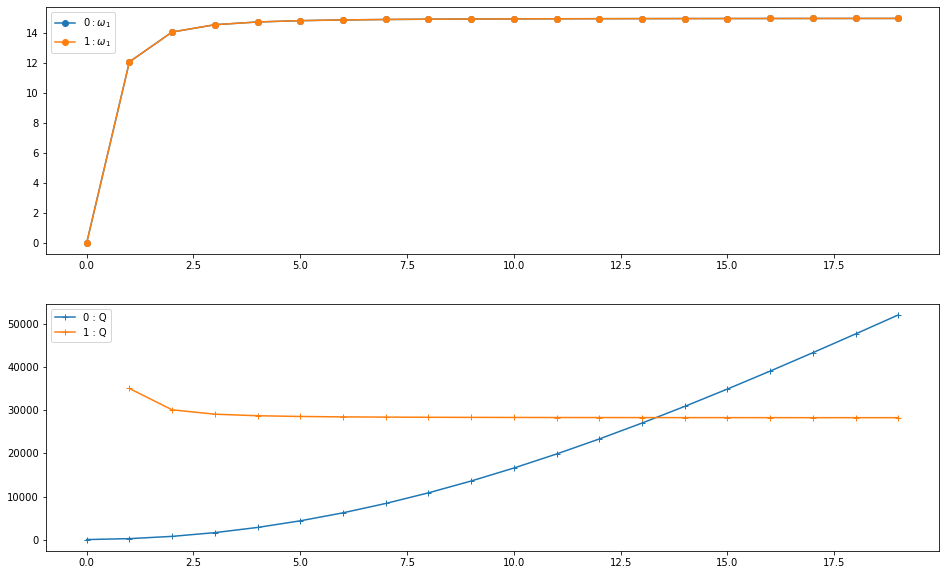

In [8]:
fig,axs = plt.subplots(2,1,figsize=(16,10))
for i,config in enumerate(res):
    axs[0].plot(config[1], "o-", label=rf"${i} : \omega_1$")
    axs[1].plot(config[3], "+-", label=f"{i} : Q")
axs[0].legend()
axs[1].legend()

In [47]:
def modes_q(x, n_jct, n_max = None):
    if n_max is None :
        n_max = n_jct//2
    [lj, cj, rj, cg, rg, ct] = x
    case = (rg is None)*2 + (rj is None)
    puls0, puls1, qs, corr = [], [], [], []
    for k in range(1,n_max):
        mod = 1-np.cos(np.pi*k/n_jct)
        ck = cg/2 + cj*mod
        lk = lj/mod
        if case == 0 :
            rk = 1/(1/(2*rg) + mod/rj)
        elif case == 1:
            rk = 2*rg
        elif case == 2:
            rk = rj/mod
        else:
            rk = None
        w0 = 1/np.sqrt(lk*ck)
        puls0.append(w0)
        if not rk is None:
            kappa = 1/(rk*ck)
            try :
                w1 = np.sqrt(w0**2-kappa**2/4)
            except:
                w1 = 0
            puls1.append(w1)
            qs.append(w1/kappa)
            corr.append(correction(k,float(np.sqrt(lk/ck)/2), float(w0), float(ct)))
        else:
            corr.append(correction(k,float(np.sqrt(lk/ck)/2), float(w0), float(ct)))
    return qs, puls0, puls1, corr

def correction(k, zk, wk0, ct):
    if k%2==0:
        def func(wkc):
            return np.tan(wkc*k*np.pi/wk0/2) + wkc*ct*zk
        def func_p(wkc):
            return k*np.pi/wk0/2*(1+(np.tan(wkc*k*np.pi/wk0/2))**2) + ct*zk
    else:
        def func(wkc):
            return np.tan(wkc*k*np.pi/wk0/2) - 1/(wkc*ct*zk)
        def func_p(wkc):
            return k*np.pi/wk0/2*(1+(np.tan(wkc*k*np.pi/wk0/2))**2) + 1/(ct*zk*wkc**2)
    if k%2 == 0 :
        x0 = wk0/k+1
        root, root_af = 0, newton(func,x0 , func_p)
        while root_af < wk0:
            root = root_af
            x0 += 2*wk0/k
            root_af = newton(func, x0, func_p)
    else:
        root = newton(func,wk0-1/k,func_p)
    return root

In [48]:
article_theoretical_data = [4.38820638820639,11.795249795249795,15.031941031941033,16.33906633906634,16.992628992628994,17.45945945945946,17.615069615069615,17.77067977067977,17.895167895167894]

In [95]:
l_j_v = 1.9 #in nH
c_j_v = 40e-6 #in nF
r_j_v = 1e8 #in Ohm
c_g_v = 0.04e-6
r_g_v = 5e11 #in Ohm
c_t_v = 0.6e-6 #in nF

q, puls0, puls1, corr = modes_q([l_j_v,c_j_v,r_j_v,c_g_v,r_g_v,c_t_v], 80, 10)

Q_res = 521478.8223878369


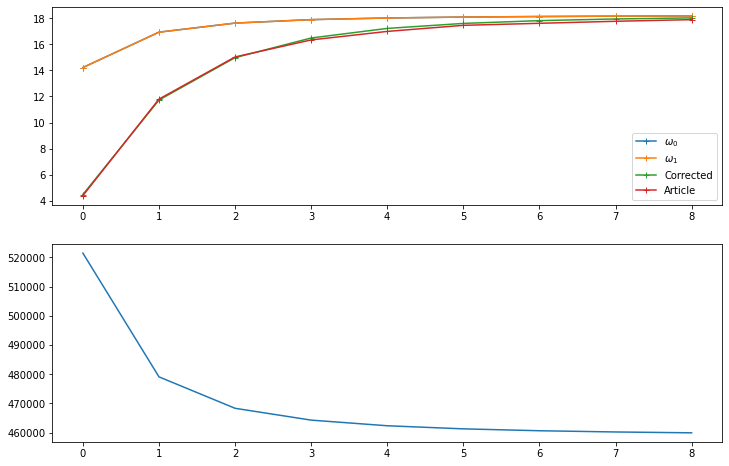

In [96]:
mode_max = 9
fig,ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot([el/2/np.pi for el in puls0][:mode_max],"+-", label=r"$\omega_0$")
ax[0].plot([el/2/np.pi for el in puls1][:mode_max],"+-", label=r"$\omega_1$")
ax[0].plot([el/2/np.pi for el in corr][:mode_max],"+-", label=r"Corrected")
ax[0].plot(article_theoretical_data,"+-", label=r"Article")
ax[0].legend()
if len(q)>0:
    print(f"Q_res = {q[0]}")
ax[1].plot(q[:9])
plt.show()